In [1]:
using Lux,LuxCUDA # Neural network definition and training
using TaylorDiff # Automatic differentiation
using Optimization # Optimization problem solving
using Optimisers # Optimizers such as Adam
using Random # Random number generation
using Plots # Plotting utilities
using Zygote # Automatic differentiation
using ComponentArrays # Array utilities for handling model parameters
using Printf # Advanced formatted printing
using LinearAlgebra # Linear algebra operations
using OptimizationOptimisers # Optimization extensions for Optimisers
using OptimizationOptimJL # Optimization extensions for LBFGS
using QuasiMonteCarlo, Distributions # Sampling utilities

In [2]:
# Seeding for reproducibility
rng = Random.default_rng() # Random number generator
Random.seed!(rng, 0) # Seed value

TaskLocalRNG()

In [3]:
# Device configuration (CPU/GPU)
DEVICE_CPU = cpu_device()   # CPU device
DEVICE_GPU = gpu_device()   # GPU device

(::CUDADevice{Nothing}) (generic function with 1 method)

In [4]:
# Physical domain colocation points
lb = [-1.0, -1.0] # Lower bound
ub = [1.0, 1.0] # Upper bound
xy_p = Float32.(QuasiMonteCarlo.sample(1000, lb, ub, LatinHypercubeSample())) #|> DEVICE_GPU # Sample points

# Separar las coordenadas x e y
x_p = Array(xy_p[1, :]) # x coordinates Physical domain colocation points
y_p = Array(xy_p[2, :]) # y coordinates Physical domain colocation points

# Boundary colocation points
bc_len = 20 # Number of boundary colocation points
x_bc = rand(Float32, bc_len) * 2 .- 1 # x coordinates Boundary colocation points
y_bc = rand(Float32, bc_len) * 2 .- 1 # y coordinates Boundary colocation points
xy_bc = hcat(
    stack((x_bc, zeros(Float32, bc_len).-1.0f0); dims=1),
    stack((x_bc, zeros(Float32, bc_len).+1.0f0); dims=1),
    stack((zeros(Float32, bc_len).-1.0f0, y_bc); dims=1),
    stack((zeros(Float32, bc_len).+1.0f0, y_bc); dims=1)
) # Boundary colocation points

# Separar las coordenadas x e y de los puntos de contorno
x_bc = xy_bc[1, :] # x coordinates Boundary colocation points
y_bc = xy_bc[2, :] # y coordinates Boundary colocation points

80-element Vector{Float32}:
 -1.0
 -1.0
 -1.0
 -1.0
 -1.0
 -1.0
 -1.0
 -1.0
 -1.0
 -1.0
  ⋮
 -0.2102009
  0.28724027
 -0.8291712
  0.888847
  0.72676516
 -0.13726246
  0.59503794
  0.09037399
  0.96150565

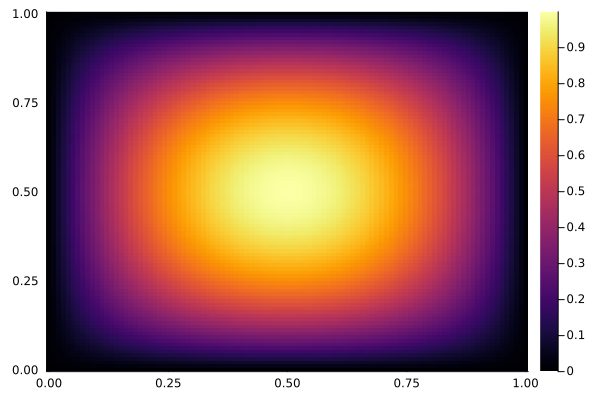

In [9]:
# Define the analytic function
function analytical_solution(x, y)
    return @. 16 * x * (1 - x) * y * (1 - y)
end

analytical_solution(xy) = analytical_solution(xy[1, :], xy[2, :])

# Plotting the analytical solution
grid = range(0.0f0, 1.0f0; length=100)
xy = stack([[elem...] for elem in vec(collect(Iterators.product(grid, grid)))]) |> DEVICE_GPU 
true_output = Array(reshape(analytical_solution(xy), 100, 100))
heatmap(grid, grid, true_output)

In [7]:
# Neural network definition
# Architecture: Network with multiple dense layers and tanh activation
const HIDDEN_UNITS = 100
model = Chain(
    Dense(2 => HIDDEN_UNITS, tanh),
    Dense(HIDDEN_UNITS => HIDDEN_UNITS, tanh; init_weight=Lux.glorot_uniform, init_bias=Lux.zeros32),
    Dense(HIDDEN_UNITS => HIDDEN_UNITS, tanh; init_weight=Lux.glorot_uniform, init_bias=Lux.zeros32),
    Dense(HIDDEN_UNITS => HIDDEN_UNITS, tanh; init_weight=Lux.glorot_uniform, init_bias=Lux.zeros32),
    Dense(HIDDEN_UNITS => 1)
)

# Model initialization
parameters, states = Lux.setup(rng, model)  # Initial parameters and states
parameters = ComponentArray(parameters) |> DEVICE_GPU    # Move parameters to the device
states = states |> DEVICE_GPU  # Move states to the device
smodel = StatefulLuxLayer{true}(model, parameters, states)

StatefulLuxLayer{true}(
    Chain(
        layer_1 = Dense(2 => 100, tanh),  # 300 parameters
        layer_2 = Dense(100 => 100, tanh),  # 10_100 parameters
        layer_3 = Dense(100 => 100, tanh),  # 10_100 parameters
        layer_4 = Dense(100 => 100, tanh),  # 10_100 parameters
        layer_5 = Dense(100 => 1),      # 101 parameters
    ),
)         # Total: 30_701 parameters,
          #        plus 0 states.

In [8]:
# Callback function
# Monitors training progress
function callback(state, l)
    state.iter % 100 == 1 && @printf "Iteration: %5d, Loss: %.6e\n" state.iter l
    return l < 1e-8  # Stop if loss is sufficiently small
end

# Loss function definition
# Uses adjoint method for gradient computation
function loss_adjoint(parameters, (xy_p, xy_bc, true_output_p, true_output_bc))
    u_p = smodel(xy_p, parameters)  # Network prediction

    dpred_p = TaylorDiff.derivative(smodel, xy_p, Float32.(ones(size(xy_p))), Val(1))

    pred_bc = smodel(xy_bc, parameters)  # Network prediction
    loss_p = MSELoss()(u_p, true_output_p) # Mean squared error loss
    loss_bc = MSELoss()(pred_bc, true_output_bc) # Mean squared error loss
    loss = loss_p + loss_bc
    return loss
end

loss_adjoint (generic function with 1 method)